# Loading the Data

In [10]:
import pandas as pd

# Load the dataset
file_path = 'input_game.csv'
game_data = pd.read_csv(file_path)

game_data.head()

,game_id,p1_id,p2_id,p1_action,p2_action,turn
0,0,174,125,TRUST,CHEAT,1
1,0,174,125,CHEAT,TRUST,2
2,0,174,125,TRUST,TRUST,3
3,0,174,125,TRUST,TRUST,4
4,0,174,125,TRUST,TRUST,5


# Engineering features representing each strategy

In [11]:
import numpy as np

# Extracting features for each player
players_features = {}
# Sort the data by turn
game_data = game_data.sort_values(by=['game_id', 'turn'])
for game_id in game_data['game_id'].unique():
    game = game_data[game_data['game_id'] == game_id]
    for _, row in game.iterrows():
        for player_id, action, opponent_action in [(row['p1_id'], row['p1_action'], row['p2_action']), 
                                                    (row['p2_id'], row['p2_action'], row['p1_action'])]:
            if player_id not in players_features:
                players_features[player_id] = {
                    'actions': [],
                    'opponent_actions': [],
                    'per_game_actions': [],
                    'per_game_opponent_actions': []
                }
            players_features[player_id]['actions'].append(action)
            players_features[player_id]['opponent_actions'].append(opponent_action)
        for player_id in [row['p1_id'], row['p2_id']]:
            players_features[player_id]['per_game_actions'].append(players_features[player_id]['actions'])
            players_features[player_id]['per_game_opponent_actions'].append(players_features[player_id]['actions'])

# Calculating Features

Due to computational constraints of our laptops, we have only added some basic features. More features like historical_trust_vs_cheat_ratio, opponent_cheating_threshold_strategy, and tit_for_tat_behavior can be added

In [12]:
# Calculate features
for player_id, features in players_features.items():
    actions = features['actions']
    opponent_actions = features['opponent_actions']
    
    # Frequency of TRUST vs CHEAT
    trust_freq = actions.count('TRUST') / len(actions) # models prior probability of TRUST
    cheat_freq = actions.count('CHEAT') / len(actions) # models prior probability of CHEAT
    
    # Reaction to opponent's TRUST or CHEAT
    reactions_after_opponent_trust = [actions[i] for i in range(1, len(actions)) if opponent_actions[i-1] == 'TRUST']
    reactions_after_opponent_cheat = [actions[i] for i in range(1, len(actions)) if opponent_actions[i-1] == 'CHEAT']
    
    # Frequency of each response
    trust_after_trust = reactions_after_opponent_trust.count('TRUST') / len(reactions_after_opponent_trust) if reactions_after_opponent_trust else 0
    cheat_after_trust = reactions_after_opponent_trust.count('CHEAT') / len(reactions_after_opponent_trust) if reactions_after_opponent_trust else 0
    trust_after_cheat = reactions_after_opponent_cheat.count('TRUST') / len(reactions_after_opponent_cheat) if reactions_after_opponent_cheat else 0
    cheat_after_cheat = reactions_after_opponent_cheat.count('CHEAT') / len(reactions_after_opponent_cheat) if reactions_after_opponent_cheat else 0
    
    # Tendency to alternate between TRUST and CHEAT
    alternations = 0
    for i in range(len(actions) - 1):
        if actions[i] != actions[i + 1]:
            alternations += 1
    tendency_to_alternate = alternations / (len(actions) - 1) if len(actions) > 1 else 0
    
    # Construct Feature for each player
    strategy_signature = (trust_freq, cheat_freq, trust_after_trust, cheat_after_trust, trust_after_cheat, cheat_after_cheat, tendency_to_alternate)
    features['strategy_signature'] = strategy_signature

# Finding unique datapoints

In [13]:

# Now, identify unique strategies based on the extracted features
unique_strategies = set()
for features in players_features.values():
    strategy_signature = features['strategy_signature']
    unique_strategies.add(strategy_signature)

# The total number of distinct strategies
N = len(unique_strategies)
N

201

good, this value should be 201, we have a different feature vector for each player

# Problem 1: Small world and Problem 2: Birds of a feather
## K Means Clustering, and finding optimal number of clusters

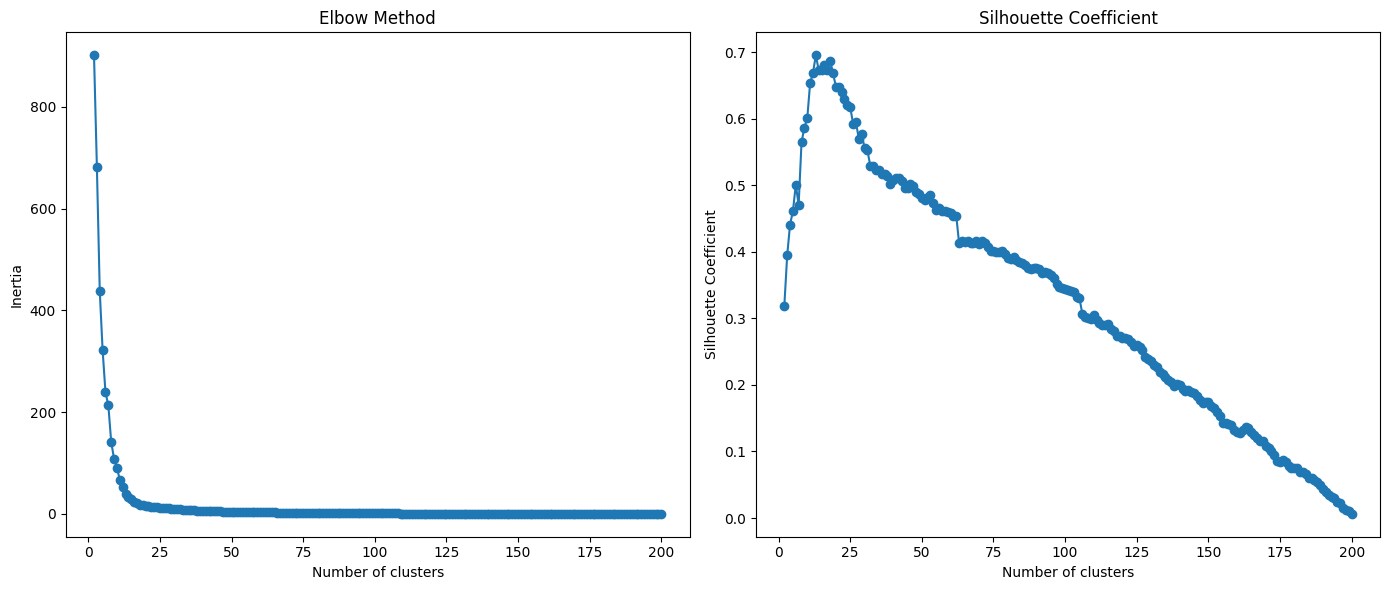

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Prepare the feature matrix
feature_matrix = []
player_ids = []
for player_id, features in players_features.items():
    feature_vector = features['strategy_signature']
    feature_matrix.append(feature_vector)
    player_ids.append(player_id)


def elbow_silhouette(feature_matrix, player_ids, method='silhouette_coeffs'):
    # Normalize the features
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(feature_matrix)

    # Find the optimal number of clusters using the Elbow Method and Silhouette Coefficient
    inertia = []
    silhouette_coeffs = []
    range_values = range(2, 201)  # Testing a range of cluster counts

    for i in range_values:
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(normalized_features)
        inertia.append(kmeans.inertia_)
        silhouette_coeffs.append(silhouette_score(normalized_features, kmeans.labels_))

    # Plotting the Elbow Method and Silhouette Coefficients
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range_values, inertia, '-o')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')

    plt.subplot(1, 2, 2)
    plt.plot(range_values, silhouette_coeffs, '-o')
    plt.title('Silhouette Coefficient')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Coefficient')

    plt.tight_layout()
    plt.show()
    # Choose the optimal number of clusters based on silhouette coefficient
    optimal_clusters = range_values[silhouette_coeffs.index(max(silhouette_coeffs))]

    # Perform K-Means clustering with the optimal number of clusters
    kmeans_optimal = KMeans(n_clusters=optimal_clusters, random_state=42)
    cluster_labels = kmeans_optimal.fit_predict(normalized_features)

    # Mapping each player to their respective cluster
    player_strategy_mapping = {player: cluster for player, cluster in zip(player_ids, cluster_labels)}

    # Count the number of players in each strategy
    strategy_counts = {i: list(cluster_labels).count(i) for i in range(optimal_clusters)}

    # Grouping players by their assigned strategy
    strategy_groups = {}
    for player_id, cluster_label in player_strategy_mapping.items():
        if cluster_label not in strategy_groups:
            strategy_groups[cluster_label] = []
        strategy_groups[cluster_label].append(player_id)

    # Sorting the players within each strategy group
    for strategy, players in strategy_groups.items():
        players.sort()

    # Ordering the groups based on the smallest player id in each group
    ordered_strategy_groups = [group for _, group in sorted(strategy_groups.items(), key=lambda item: item[1][0])]

    # Fit the K-Means model
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    kmeans.fit(normalized_features)
    centroids_normalized = kmeans.cluster_centers_

    # Convert the centroids back to the original feature space
    centroids_original = scaler.inverse_transform(centroids_normalized)

    # Count the number of players in each cluster and group player IDs by cluster
    cluster_labels = kmeans.labels_
    player_counts = np.bincount(cluster_labels)

    # Group player_ids by their cluster
    clustered_player_ids = {i: [] for i in range(optimal_clusters)}
    for player_id, cluster_label in zip(player_ids, cluster_labels):
        clustered_player_ids[cluster_label].append(player_id)

    # Prepare the data for CSV export
    csv_data = {
        'Cluster': [],
        'Centroid (Normalized)': [],
        'Centroid (Original)': [],
        'Player Count': [],
        'Player IDs': []
    }

    for i in range(optimal_clusters):
        csv_data['Cluster'].append(i)
        csv_data['Centroid (Normalized)'].append(list(centroids_normalized[i]))
        csv_data['Centroid (Original)'].append(list(centroids_original[i]))
        csv_data['Player Count'].append(player_counts[i])
        csv_data['Player IDs'].append(clustered_player_ids[i])

    # Convert the data into a DataFrame
    strategy_df = pd.DataFrame(csv_data)

    # Save the DataFrame to CSV
    csv_file_path = 'strategy_clusters.csv'  # Adjust the path as needed for your environment
    strategy_df.to_csv(csv_file_path, index=False)

    return optimal_clusters, csv_data


optimal_clusters, csv_data = elbow_silhouette(feature_matrix, player_ids)

we get 13 startegy clusters. we store the detailed output in strategy_clusters.csv.  

Now the strategies can be modeled back by looking at the centroid values

# Problem 3: Now I see you

In [15]:
# Function to interpret centroid characteristics
def interpret_centroid(centroid):
    interpretations = []
    # Interpret each component of the centroid
    if centroid[0] > 0.5:  # High frequency of trust
        interpretations.append("Highly trusting")
    else:
        interpretations.append("Less trusting")

    if centroid[1] > 0.5:  # High frequency of cheat
        interpretations.append("Often cheats")
    else:
        interpretations.append("Seldom cheats")

    if centroid[2] > 0.7:  # High trust after opponent trusts
        interpretations.append("Trusts after opponent trusts")
    elif centroid[2] < 0.3:
        interpretations.append("Distrusts despite opponent's trust")

    if centroid[3] > 0.7:  # High cheat after opponent trusts
        interpretations.append("Betrays after opponent trusts")
    elif centroid[3] < 0.3:
        interpretations.append("Remains loyal despite opponent's trust")

    if centroid[4] > 0.7:  # High trust after opponent cheats
        interpretations.append("Forgiving after being betrayed")
    elif centroid[4] < 0.3:
        interpretations.append("Unforgiving after being betrayed")

    if centroid[5] > 0.7:  # High cheat after opponent cheats
        interpretations.append("Retaliates after being betrayed")
    elif centroid[5] < 0.3:
        interpretations.append("Does not retaliate after being betrayed")

    if centroid[6] > 0.6:  # High tendency to alternate
        interpretations.append("Frequently alternates")
    elif centroid[6] < 0.4:
        interpretations.append("Rarely alternates")

    return ', '.join(interpretations)

# Add 'Analysis' to your CSV data
csv_data['Analysis'] = [interpret_centroid(centroid) for centroid in csv_data['Centroid (Original)']]

# Convert updated data into a DataFrame
strategy_df_updated = pd.DataFrame(csv_data)

# Save the updated DataFrame to CSV
updated_csv_file_path = 'strategy_clusters_analysis.csv'  # Adjust the path as needed for your environment
strategy_df_updated.to_csv(updated_csv_file_path, index=False)


the analyses for each strategy are now stored in the last column in strategy_cluster_analysis.csv

# Problem 5: Dark Forest  

Enhanced Analysis:

In the simulated environment of the "Game of Trust", the dynamics of player interactions and strategy effectiveness are significantly affected by the rate of miscommunication. As we introduce and increase miscommunication probabilities, we observe shifts in strategy performance, attributable to how each strategy processes errors in communication:

Copycat Strategy: This strategy thrives in low-miscommunication environments (below 1%). It is built on reciprocity and mutual cooperation, which leads to high rewards when both players understand each other's moves correctly. However, as miscommunication increases, the effectiveness of the Copycat strategy diminishes because the reciprocal nature of the strategy gets disrupted, leading to unnecessary retaliations and missed opportunities for cooperation.

Copykitten Strategy: This variant is more forgiving than Copycat, as it requires two consecutive cheats to trigger retaliation. This added leniency makes Copykitten the dominant strategy in environments with miscommunication rates between 1% and 10%. The strategy balances between avoiding false retaliations due to miscommunication and punishing consistent uncooperative behavior.

Grudger Strategy: Holding a grudge after being cheated k times (with k set to 1 for simplicity) becomes advantageous in environments with moderate miscommunication rates (between 10% and 20%). The Grudger's initial cooperation helps build trust when signals are mostly reliable, but its shift to relentless retaliation becomes a protective measure against frequent misunderstandings and the perceived betrayal.

Cheater Strategy: In high-miscommunication environments (above 20%), the complexity and subtlety of conditional strategies lose their effectiveness due to the high likelihood of signals being incorrectly interpreted. In these scenarios, the Cheater, unconcerned with the fidelity of communication, unexpectedly becomes the most successful. This strategy does not rely on the opponent’s moves and thus remains unaffected by misinterpretation, ensuring a steady, albeit lower, return irrespective of the communication quality.

# Problem 6: Master of All  

To create a strategy that aims to outperform existing strategies, including "Copykitten", let's think about a more adaptive and resilient strategy. We'll call this strategy "AdaptiveStrategist". The idea behind this strategy is to analyze the opponent's past behavior more comprehensively and adjust our moves accordingly. This strategy will:

Start with cooperation (TRUST).
Retaliate immediately if cheated upon (to avoid exploitation).
Return to TRUST if the opponent has been trustworthy for the last few moves (to encourage mutual cooperation).
Incorporate a forgiveness mechanism after a certain number of rounds to break continuous retaliation loops.
Adapt based on the frequency of the opponent's TRUST and CHEAT actions.

In [16]:
from enum import Enum
from typing import List
from collections import Counter

class Action(Enum):
    TRUST = 1
    CHEAT = 2

def adaptive_strategy(past_self: List[Action], past_opponent: List[Action]) -> Action:
    # Start with trust
    if not past_self:
        return Action.TRUST
    
    # Analyze opponent's past behavior
    opponent_behavior = Counter(past_opponent)
    trust_percentage = opponent_behavior.get(Action.TRUST, 0) / len(past_opponent)
    
    # Retaliate if cheated upon recently
    if past_opponent[-1] == Action.CHEAT:
        return Action.CHEAT
    
    # If the opponent has been mostly trustworthy, continue to trust
    if trust_percentage > 0.7:
        return Action.TRUST
    
    # Incorporate forgiveness mechanism - forgive after two CHEATs
    if len(past_self) > 3 and past_opponent[-1] == Action.TRUST and past_opponent[-2] == Action.CHEAT and past_opponent[-3] == Action.CHEAT:
        return Action.TRUST
    
    # Default to trusting if the opponent's behavior is not extreme
    return Action.TRUST

# Test the strategy
past_self_example = [Action.TRUST, Action.CHEAT, Action.TRUST]
past_opponent_example = [Action.TRUST, Action.CHEAT, Action.CHEAT]
next_move = adaptive_strategy(past_self_example, past_opponent_example)
print(f"Next Move: {next_move}")

Next Move: Action.CHEAT
